In [3]:
!pip install Cython
!pip install fbprophet

from fbprophet import Prophet

  Using cached Cython-0.29.30-py2.py3-none-any.whl (985 kB)


  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached pystan-3.4.0-py3-none-any.whl (13 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached holidays-0.13-py3-none-any.whl (172 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached PyMeeus-0.5.11.tar.gz (5.4 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached korean_lunar_calendar-0.2.1-py3-none-any.whl (8.0 kB)
  Using cached hijri_converter-2.2.4-py3-none-any.whl (14 kB)
  Using cached ephem-4.1.3-cp39-cp39-win_amd64.whl (1.4 MB)
  Using cached pysimdjson-3.2.0-cp39-cp39-win_amd64.whl (157 kB)
  Using cached aiohttp-3.8.1-cp39-cp39-win_amd64.whl (554 kB)
  Using cached pystan-3.3.0-py3-none-

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [45 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib
  creating build\lib\fbprophet
  creating build\lib\fbprophet\stan_model
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\Dell5520\AppData\Local\Temp\pip-install-oi00m6o1\fbprophet_c03539f20a6a45ad98fba666294de743\setup.py", line 122, in <module>
      setup(
    File "C:\Users\Dell5520\PycharmProjects\personal\machine_learning\venv\lib\site-packages\setuptools\__init__.py", line 153, in setup
      return distutils.core.setup(**attrs)
    File "C:\Users\Dell5520\AppData\Local\Programs\Python\Python39\lib\distutils\core.py", line 148, in setup
      dist.run_commands()
    File "C:\Users\Dell5520\AppData\Local\Programs\Python\Python39\lib\distutils\dist.

# Table of Contents

* [Prophet Example](#chapter1)

* [Card Data Capture](#chapter2)
    * [Part A](#section_2_1)
    * [Part B](#section_2_2)

* [Roulette Data Capture](#chapter3)
    * [Part A](#section_3_1)
    * [Part B](#section_3_2)

* [Medical Trial](#chapter4)

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter

In [8]:
data_path = os.path.join(os.path.abspath('.'), 'data', 'time_series')

# 1. Prophet example<a class="anchor" id="chapter1"></a>

In [ ]:
# datetime index fct

def timestamp_index(df : pd.DataFrame, date_col : str, frequency = "D"):
    '''
    Turns a column of string form dates (YYYY-MM-DD) into a datetime index
    Inputs:
        df        : Your dataframe
        date_col  : The column with the date strings
        frequency : The frequency of your dates
    Outputs:
        df : The same dataframe, but with the date column as the index
    '''
    
    df[date_col] = pd.to_datetime(df[date_col], format='%Y-%m-%d')
    df = df.set_index(date_col)
    df = df.asfreq(frequency)

    return df

# empty value filler

def fill_in_empties(df : pd.DataFrame, features : list, start_dates: list, verbose = 1):
    '''
    Function to fill in the NaN values for each of the listed features, from each of the start dates
    Inputs:
        df          : The dataframe that you want to add to
        features    : The features that we want to fill in the missing values
        start_dates : The date from which after we fill in everything
        verbose     : 1 -> Show how many entries are missing from final df, else -> nothing
    Returns:
        new_df : A new dataframe with filled in values
    '''
    #Make sure everything is in order before starting
    assert len(features) == len(start_dates)
    for f in features:
        assert f in df.columns
    for sd in start_dates:
        assert sd in df.index
    
    #Create new DataFrame with filled in values
    new_df = pd.DataFrame(columns = df.columns, index = df.index)
    
    #Fill in empty values, using interpolation, forward fills and backward fills
    for f,sd in zip(features, start_dates):
        new_df.loc[sd:, f] = df.loc[sd:, f]
        new_df.loc[sd:, f] = new_df.loc[sd:, f].interpolate()
        new_df.loc[sd:, f] = new_df.loc[sd:, f].ffill()
        new_df.loc[sd:, f] = new_df.loc[sd:, f].bfill()
        
        if (verbose == 1):
            #Check for any missing values
            is_missing = new_df.loc[sd:, f].copy().isna()
            print(f'Number of items missing from {f} is {is_missing.sum()}')
    
    return new_df

# get the timestamps for a single training and tst point

def get_dates(df : pd.DataFrame,start_date = "2012-01-01", train_duration = '104w', forecast_horizon = '2w'):
    '''
    Returns a dictionary, containing the timestamps for:
            {"training_start" : training point start date,
             "training_end"   : training point end date,
             "test_start"     : test point start date,
             "test_end"       : test point end date}
    Inputs:
        df               : The data frame that you want to get the dates from
        start_date       : A string of the form "YYYY-MM-DD" that will be the start of the training days
        train_duration   : A string of the form '{# weeks}w' that will be how long your training data will be
        forecast_horizon : A string of the form '{# weeks}w' that will be how long your test data will be    
    Outputs:
        The dictionary of dates
    '''
    #convert strings to timestamps
    train_start = pd.to_datetime(start_date, format='%Y-%m-%d')
    forecast_horizon = pd.Timedelta(forecast_horizon)
    train_duration = pd.Timedelta(train_duration)

    #checking that we can create the dictionary
    assert not df.loc[train_start].empty
    assert not df.loc[train_start + train_duration + forecast_horizon].empty

    train_end = train_start + train_duration
    test_start = train_end + pd.Timedelta(days = 1)
    test_end = train_end + forecast_horizon

    return {"train_start" : train_start, "train_end" : train_end, "test_start" : test_start, "test_end" : test_end}


In [ ]:
# prophet model class

class ProhpetModel:
    def __init__(self, yearly = True, daily = True):
        #can specify the number of coefficients in each seasonality by parsing an int
        #seasonal_mode = "multiplicative"
        '''
        Initilizing method of the class
        Attributes:
            self.model : The Facebook Prophet model object
        Inputs:
            yearly_seasonality : Whether the model incorporates yearly seasonality
                True/False : 1 or no seasonality elements
                int        : Number of seasonality elements in model
            daily_seasonality  : Whether the model incorporates daily seasonality
                True/False : 1 or no seasonality elements
                int        : Number of seasonality elements in model
        '''
        self.model = Prophet(yearly_seasonality = yearly, daily_seasonality = daily)
        
    def fit(self, X_train):
        '''
        The method to fit the model
        Inputs:
            X_train : The data we want to fit our model on - has two columns with set column labels:
                "ds" : The timestamps of the data
                "y"  : The data on each timestamp
        '''
        self.model.fit(X_train)
        
    def predict(self, X_test):
        '''
        Forecasts data for given dates
        Inputs:
            X_test : A dataframe containing the dates you want to forecast for - has one column with a set column label:
                "ds" : The timestamps of the forecast points
        Outputs:
            A dataframe of the forecast data
        '''
        return self.model.predict(X_test)

    def plot(self, forecast):
        '''
        Creates a plot of the training and forecast data
        '''
        fig = self.model.plot(forecast)
        ax = fig.gca()
        return fig, ax

    def plot_components(self, forecast):
        '''
        Creates plots of the forecast components
        '''
        fig = self.model.plot_components(forecast)
        ax = fig.gca()
        return fig, ax

    def plot_forecast(self, forecast):
        '''
        Create a plot of the last part of the training data and the forecast data
        '''
        start = forecast.iloc[0,0] - pd.Timedelta(days = len(forecast))
        end = forecast.iloc[len(forecast)-1,0]

        fig = self.model.plot(forecast)
        ax = fig.gca()
        ax.set_xlim(start, end)

        return fig, ax

In [ ]:
FILEPATH = os.path.join(data_path, 'power', 'german_daily_power.csv')

df = pd.read_csv(FILEPATH)
df.drop(columns = ["Wind+Solar"], inplace = True)
df = timestamp_index(df, date_col = "Date")

#WHICH FEATURES WE WANT TO FILL IN AND FROM WHICH START DATES
#--Each start date is for their respective feature
all_features = ["Consumption", "Wind", "Solar"]
start_dates = ["2006-01-01", "2010-01-01", "2012-01-01"]  

#FILL IN NaNs
df = fill_in_empties(df ,features = all_features, start_dates = start_dates, verbose = 0)

#GET DATES FOR DATA
dates = get_dates(df, train_duration = "208w", forecast_horizon = "4w")

#CREATE TRAINING AND TEST DATA
feature = "Consumption"
X_train = df.loc[dates["train_start"] : dates["train_end"]][[feature]]
X_test = df.loc[dates["test_start"] : dates["test_end"]][[feature]]

#ALTER TRAINING AND TEST DATA TO GET IT INTO THE CORRECT FORM FOR PROPHET
X_train.reset_index(inplace = True)
X_train.rename(columns = {"Date" : "ds", feature : "y"}, inplace = True)

X_test.reset_index(inplace = True)
X_test.drop(columns = [feature], inplace = True)
X_test.rename(columns = {"Date" : "ds"}, inplace = True)

#CREATE PROPHET MODEL
model = ProhpetModel()
model.fit(X_train)
forecasts = model.predict(X_test)

#SAVE FIGURE
fig, ax = model.plot_forecast(forecasts)
ax.set_xlabel("Date")
ax.set_ylabel(feature)
FIGURE_PATH = "forecast_plot.png"
plt.savefig(FIGURE_PATH)

print("\nAll Good\n")

# Card Data Capture<a class="anchor" id="chapter2"></a>

What chance the Ace of Spades in the next $n$ turns? How to generate 

## Part A: Three ways to generate sample data

## The Overall Brief:

<i> Alice and Bob have been experimenting with a simple card process in which the 52 cards in a shuffled pack are turned over one by one, until the ace of spades is revealed. At that point, the pack is reshuffled the process restarts. They are interested in how frequently they can observe a sequence of $n$ card turns without even once seeing the 'Ace of Spades event'. 
    
1. Alice suggests the first case they consider is when they always start the observation at the start of the process (Alice's case). 
1. Bob thinks that the next case they should consider (Bob's case) is when they start the observation at some random (and unknown) point in the process.
1. They both agree that an interesting third case is the same as above (Bob's case), but when the starting point is known (rather than unknown).

Our task is to help Alice and Bob investigate these different cases, in each case obtain the estimate they are looking for (namely, 'whats the probability of observing $n$ turns without seeing the Ace of Spades')

- Part A: generate the simulated data for the three cases. 
- Part B: estimate the survival probabilities as a function of $n$.
- Part C: further cases to consider.
</i>

## Part A<a class="anchor" id="section_2_1"></a>


write functions to output dataframes for the three cases under consideration:
- Card.A.1: Alice's case (always starting from a full deck of cards). One row per observation, to include columns for $d$, $n$ and whether the observation included the ace of spades event. 
- Card.A.2: Bob's case (starting at some unknown random point in the process). Same format as above.
- Card.A.3: The third case (starting at some known random point $p$ since the last reshuffle). Same format as above, but include a column for $p$. 

### Censoring

Right censoring: Event happens after we stop observing

Left censoring: Event happens before we observe 

In [10]:
# Card A1

def get_alice_df(num_obs = 10000, n=52, random_seed = 123):
    
    np.random.seed(random_seed)
        
    durations = []
    has_event = []
    
    for obs in range(num_obs):
        
        cards = np.arange(0, 52)
        np.random.shuffle(cards) 
        search_result = np.where(cards[0:n] == 0) 
        # does the first n cards contain a zero (ace of spades)?
        
        if len(search_result[0]) > 0:
            has_event.append(1)
            duration = search_result[0][0]
            durations.append(duration)
        else:
            has_event.append(0)
            durations.append(n)
            
        # want to capture the following data:
        # did we observe 'card 0' in the first n shuffled cards? (has event=0/1)
        # if so, how many cards did we turn over, to observe it? (duration)
            
    return pd.DataFrame({'duration':durations, 'has_event': has_event})

 

df = get_alice_df(random_seed=124)
df.to_csv(os.path.join(data_path, 'cards', 'alice_cards_dataset.csv'))
df.head()

,duration,has_event
0,45,1
1,16,1
2,43,1
3,38,1
4,32,1


In [12]:
# Card A2

def get_bob_df(num_obs = 10000, n=52, random_seed = 123):
    
    np.random.seed(random_seed)
    # make a single sequence of many shuffled packs of cards:
    
    single_sequence = []
    
    for obs in range(num_obs):
        
        cards = np.arange(0,52)
        np.random.shuffle(cards)
        duration = np.where(cards==0)[0][0]
        single_sequence.extend(cards[:duration+1])

    if num_obs<10:
        pd.DataFrame({'cards': single_sequence}).to_csv(
            os.path.join(data_path, 'cards', 'bob_single_sequence.csv')
        )
    
    
    # make some random starting points, to start looking in this sequence:
    durations = []
    has_event = []
    
    obs_starting_points = np.random.randint(
        low=0, high=len(single_sequence)-52, size=num_obs
    )
    
    for starting_point in obs_starting_points:
        cards = np.array(single_sequence[starting_point:starting_point+n])
        search_result = np.where(cards==0)
        
        if len(search_result[0])>0:
            has_event.append(1)
            duration = search_result[0][0]
            durations.append(duration)
            
        else:
            has_event.append(0)
            durations.append(n)  
            
    return pd.DataFrame({'duration':durations, 'has_event': has_event})

df = get_bob_df(num_obs = 10000, n=52, random_seed=124)
df.to_csv(os.path.join(data_path, 'cards', 'bob_cards_dataset.csv'))
df.head()

,duration,has_event
0,3,1
1,3,1
2,18,1
3,30,1
4,29,1


In [13]:
# Card A3

def get_third_df(num_obs = 10000, n=52, random_seed = 123):
    
    np.random.seed(random_seed)
        
    single_sequence = []
    shuffle_indices = [0]
    
    for obs in range(num_obs):
        
        cards = np.arange(0,52)
        np.random.shuffle(cards)
        duration = np.where(cards==0)[0][0]
        shuffle_indices.append(duration+shuffle_indices[-1])
        single_sequence.extend(cards[:duration+1])

    if num_obs<10:
        pd.DataFrame({'cards': single_sequence}).to_csv(
            os.path.join(data_path, 'cards', 'third_single_sequence.csv')
        )
    
    durations = []
    has_event = []
    turns_since_shuffle = []
    
    obs_starting_points = np.random.randint(
        low=0, high=len(single_sequence)-52, size=num_obs
    )
    
    for starting_point in obs_starting_points:
        
        last_shuffle_index = [i for i in shuffle_indices if i<= starting_point][-1]
        turns_since_shuffle.append(starting_point-last_shuffle_index)
        cards = np.array(single_sequence[starting_point:starting_point+n])
        search_result = np.where(cards[0:n]==0)
        
        if len(search_result[0])>0:
            has_event.append(1)
            duration = search_result[0][0]
            durations.append(duration)
        
        else:
            has_event.append(0)
            durations.append(n)
                        
    return pd.DataFrame(
        {
            'duration':durations, 
            'has_event': has_event, 
            'turns_since_shuffle':turns_since_shuffle
        }
    )

df = get_third_df(num_obs = 10000, n=26, random_seed=124)
df.to_csv(os.path.join(data_path, 'cards', 'third_cards_dataset.csv'))
df.head()

,duration,has_event,turns_since_shuffle
0,3,1,8
1,3,1,19
2,18,1,34
3,26,0,11
4,26,0,26


## Part B<a class="anchor" id="section_2_2"></a>


Cards.B.1: Using the KaplanMeierFitter from the lifelines library, plot (on the same axes) the survival functions for  three datasets
- What differences exist between these three survival function estimates?
- Which is the best form of input to use, judging by these graphs?


Cards.B.2: Write two functions, one for Alice's dataset and one for Bob's dataset,  that each return 'the probability of observing a sequence of $n$ card turns without even once seeing the "ace of spades event"'
- How could these probability estimates be tested?

Cards.B.3: How can the extra information in the third dataset (number of turns since the last shuffle) be used to increase the accuracy of the estimate?
- And how can this be tested?

   Unnamed: 0  duration  has_event
0           0        45          1
1           1        16          1
2           2        43          1
3           3        38          1
4           4        32          1


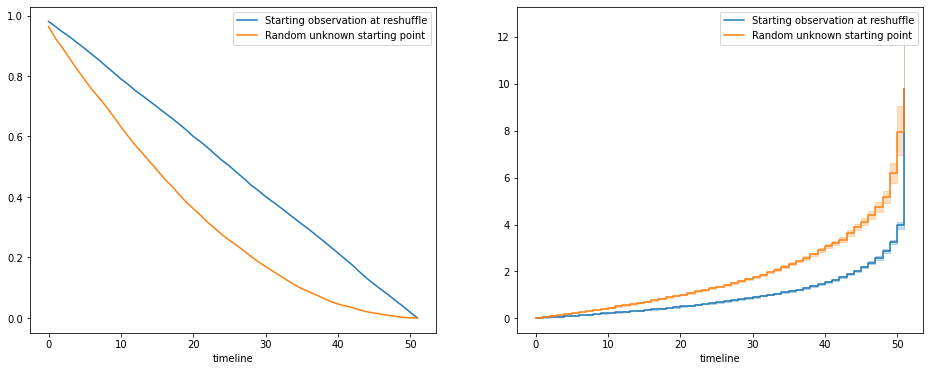

In [17]:
# Cards B1

def plot_kmf(df, label, ax):

    kmf = KaplanMeierFitter()
    kmf.fit(df['duration'], event_observed=df['has_event'], label=label)
    kmf.survival_function_.plot(ax=ax[0]) 
    naf = NelsonAalenFitter()
    naf.fit(df['duration'], event_observed=df['has_event'], label=label)
    naf.plot_cumulative_hazard(ax=ax[1], label=label)        

alice_df = pd.read_csv(
    os.path.join(data_path, 'cards', 'alice_cards_dataset.csv')
)
print(alice_df.head())
alice_df = alice_df[['duration', 'has_event']]
bob_df = pd.read_csv(
    os.path.join(data_path, 'cards', 'bob_cards_dataset.csv')
)
bob_df = bob_df[['duration', 'has_event']]

fig,ax = plt.subplots(1,2,figsize=(16,6))
plot_kmf(alice_df, label="Starting observation at reshuffle", ax=ax)
plot_kmf(bob_df, label="Random unknown starting point", ax=ax)

In [20]:
# Cards B2

def get_event_probability(model, up_to_this_time):
    return model.survival_function_.loc[up_to_this_time, 'KM_estimate']

alice_df = pd.read_csv(
    os.path.join(data_path, 'cards', 'alice_cards_dataset.csv')
)
alice_df = alice_df[['duration', 'has_event']]
alice_model = KaplanMeierFitter()
alice_model.fit(alice_df['duration'])

bob_df = pd.read_csv(
    os.path.join(data_path, 'cards', 'bob_cards_dataset.csv')
)
bob_df = bob_df[['duration', 'has_event']]
bob_model = KaplanMeierFitter()
bob_model.fit(bob_df['duration'])


alice_prob = get_event_probability(alice_model, 10)
bob_prob = get_event_probability(bob_model, 10)
print(f'alice prob:\t{round(alice_prob, 3)}\nbob prob:\t{round(bob_prob, 3)}')

alice prob:	0.79
bob prob:	0.633


# Roulette Data Capture<a class="anchor" id="chapter3"></a>

What chance of a zero in the next $n$ spins (while I'm at the table)

## Part A: Three ways to generate sample data

## The Overall Brief:

<i> Alice and Bob have been modelling how frequently they can sit through a sequence of roulette spins without it even once landing on the number zero. 
'If I sit at the table for $n$ spins, how do we estimate from the data, the probability that every spin lands on a non-zero number?' 
    
1. Alice thinks that the correct input data to simulate is the single sequence of numbers as they occur from the wheel, e.g.  (1,5,20, 0, 36,2,3,4,0, ...}. In this way, the runs of non-zero-numbers (in between the zeros) can be analysed. We'll call this type of input data the 'single sequence'.  
1. Bob thinks that the simulated data must also account for when they sit down at the wheel: in general they won't sit down at the start of the runs of non-zero-numbers, and so they will only be present for some fraction of the total run of non-zero numbers. It is the length of these sequences (that don't necessarily start at a zero) that we need to be measuring. We'll call this type of input data 'samples from single sequence'. 
1. They both agree that another type of data simulation that they could compare against, would be to model $p$ players independently, each sitting down to their own separate roulette wheel, at the start of its sequence of up to $n$ spins. 

Our task is to help Alice and Bob investigate these different data sampling strategies and obtain the estimate they are looking for. 

- Part A: generate the three types of simulated data: single-sequence, sampled-single sequence, independent-sequences. 
- Part B: obtain survival and cumulative hazard functions for these datasets, help Alice and Bob decide who is right.
- Part C: show confidence intervals for these estimates, compare with theoretical prediction.
</i>

## Part A<a class="anchor" id="section_3_1"></a>


Roulette A1: write a function that outputs the 'single sequence' DataFrame, corresponding the Alice's suggestion, above. There's one row of the DataFrame for each 'zero event' (meaning a spin that lands on the number zero). There's just a single column, called `duration`, storing the number of spins since the previous zero event. 

- Each row of the DataFrame will represent an event occurence, i.e. a spin of the wheel that lands on number zero. 
- Let's assume European Roulette wheels, that have a single zero (rather than American wheels that also have a double zero). 
- The DataFrame should hold an integer column, called 'duration', that represents the number of spins since the previous event. 
- For example, if the wheel selected two consecutive zeros, one after the other, then these two events will be stored as two rows, and the value stored in the second row will be '1': the number of spins since the previous zero. 
- The DataFrame can have a simple integer index. 
- Aim to generate at least 10,000 events to store in this DataFrame. 
- Save this as `single_sequence.csv`
- Hint: You can do this by generating a sequence of simulated spins from a single roulette wheel, and count up the spins between each zero event, and store each one in the 'single sequence' DataFrame.
    

Roulette A2: write a function to genenerate the 'samples from single sequence' dataframe, corresponding to Bob's suggestion, above. Do this by simulating a sequence of wheel spins, and the arrival of players at random points in this sequence, to observe up to $n$ elements of it. 
- The `duration` column should store the number of spins that this player had observed, before the first observation of the spin that results in a zero (the event). 
- The `has_event` column should either store `True` (if the player observes a zero-event) or `False` (if no such event occurred during the $s^{\prime}$ spins of the wheel).  
- Multiple players can observe the overlapping portions of the sequence, it isn't a requirement to make their observations  mutually exclusive. 
- Aim to generate at least 10,000 rows in this DataFrame. 
- Save this DataFrame as `samples_from_single_sequence..csv`


Roulette A3: write a function to generate the 'independent sequences' dataframe. 
- In this simulation, each player observes their own 'private' sequence of up to $s^{\prime}$ roulette spins, from the start. 
- As in the above case, the DataFrame has two columns, `duration` and `has_event`. 
- Each row of the dataframe stores the number of spins observed by the player before they observed the event; or (if no event was observed), the value of $s^{\prime}$ and `has_event=False`.
- Aim to generate at least 10,000 rows in this DataFrame. 
- Save this DataFrame as `independent_samples.csv`
    
    


In [26]:
# roulette A1

def get_single_sequence(
    num_ticks = 400000, high=37, event_outcome = 0, random_seed = 123
):
    
    np.random.seed(random_seed)
    outcomes = np.random.randint(low=0, high=high, size=num_ticks)
    events = list(outcomes == event_outcome)
    
    durations = []
    duration = 0
    
    for event in events:
        
        if event:
            duration += 1
            durations.append(duration)
            duration = 0
        else:
            duration += 1
    
    return pd.DataFrame({'duration': durations})

df = get_single_sequence(random_seed=124)
df.to_csv(os.path.join(data_path, 'roulette', 'single_sequence.csv'))
df.head()

,duration
0,6
1,11
2,52
3,16
4,10


In [27]:
# Roulette A2

def get_samples_from_single_sequence(
    num_spins=100000, num_obs = 3000, obs_length = 100, 
    high=37, event_outcome = 0, random_seed = 123
):
    
    np.random.seed(random_seed)
    outcomes1d = np.random.randint(low=0,high=high,size=num_spins)
    starting_positions = np.random.randint(
        low=0,high=num_spins-obs_length,size=num_obs
    )
    outcomes = np.empty((num_obs, obs_length))
    
    for s in range(num_obs):
        outcomes[s,:] = outcomes1d[
            starting_positions[s]:starting_positions[s] + obs_length
        ]
        
    event2d = outcomes == event_outcome
    durations = np.empty(num_obs)
    event1d = np.zeros(num_obs)
    
    for obs in range(0,num_obs):
        counter = 0
        while counter < obs_length:
            if event2d[obs,counter]:
                durations[obs] = counter
                event1d[obs] = 1
                break
            counter += 1
        if event1d[obs] ==0:
            durations[obs] = counter
            
    return pd.DataFrame({'duration':durations, 'has_event':event1d})
            
samples_from_single_sequence_df = get_samples_from_single_sequence()
samples_from_single_sequence_df.to_csv(
    os.path.join(data_path, 'roulette', 'samples_from_single_sequence.csv')
)
samples_from_single_sequence_df.head()

,duration,has_event
0,14.0,1.0
1,51.0,1.0
2,3.0,1.0
3,90.0,1.0
4,56.0,1.0


In [28]:
# roulette A3

def get_independent_samples(
    num_obs = 3000, obs_length = 100, high=37, 
    event_outcome = 0, random_seed= 123
):

    np.random.seed(random_seed)
    outcomes = np.random.randint(low=0,high=high,size=(num_obs, obs_length))                                 
    event2d = outcomes == event_outcome
    durations = np.empty(num_obs)
    event1d = np.zeros(num_obs)
    
    for obs in range(0,num_obs):
        counter = 0
        while counter < obs_length:
            if event2d[obs,counter]:
                durations[obs] = counter
                event1d[obs] = 1
                break
            counter += 1
        if event1d[obs] ==0:
            durations[obs] = counter
            
    return pd.DataFrame({'duration':durations, 'has_event':event1d})

independent_samples_df = get_independent_samples()
independent_samples_df.to_csv(
    os.path.join(data_path, 'roulette', 'independent_samples.csv')
)
independent_samples_df.head()

,duration,has_event
0,35.0,1.0
1,100.0,0.0
2,27.0,1.0
3,23.0,1.0
4,24.0,1.0


## Part B<a class="anchor" id="section_3_1"></a>


Roulette.B.1: Using the KaplanMeierFitter from the lifelines library, plot (on the same axes) the survival functions for the three datasets. 
- What differences exist between these three estimates of the survival function, for this process?
- Which is the best form of input to use, judging by these graphs?


Roulette.B.2: The probability that all $n$ spins are non-zero is survival function for that value of n. 
- How could these probability estimates be tested?

Roulette.B.3: use the NelsonAalenFitter to plot the cumulative hazard function.
- What is the shape of this cumulative hazard function? What is the intuitive interpretation of this? What does this imply for for the (non-cumulative) hazard function?
- What is the explanation for the change in confidence intervals towards the top right of the graph?

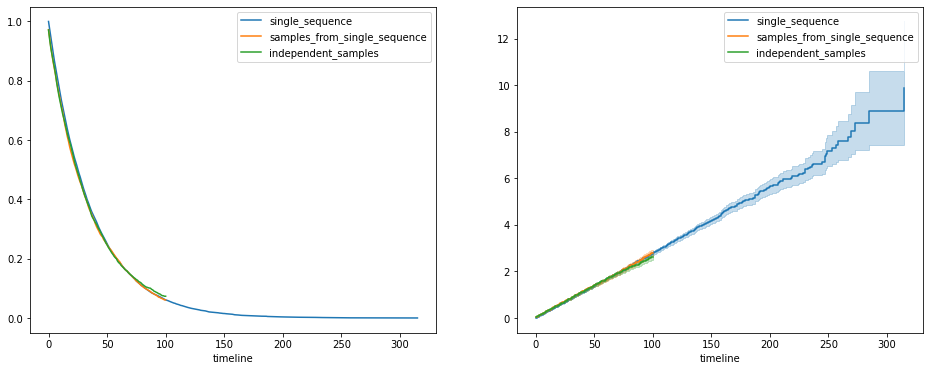

In [30]:
# roulette B1

def plot_kmf(df, label, ax):

    kmf = KaplanMeierFitter()
    kmf.fit(df['duration'], event_observed=df['has_event'], label=label)
    kmf.survival_function_.plot(ax=ax[0]) 
    naf = NelsonAalenFitter()
    naf.fit(df['duration'], event_observed=df['has_event'], label=label)
    naf.plot_cumulative_hazard(ax=ax[1], label=label)
    
independent_samples_df = pd.read_csv(
    os.path.join(data_path, 'roulette', 'independent_samples.csv')
)
independent_samples_df = independent_samples_df[
    ['duration', 'has_event']
]

single_sequence_sampled_df = pd.read_csv(
    os.path.join(data_path, 'roulette', 'samples_from_single_sequence.csv')
)
single_sequence_sampled_df = single_sequence_sampled_df[
    ['duration', 'has_event']
]

single_sequence_df = pd.read_csv(
    os.path.join(data_path, 'roulette', 'single_sequence.csv')
)
single_sequence_df = single_sequence_df[['duration']]
single_sequence_df['has_event'] = 1


fig,ax = plt.subplots(1,2,figsize=(16,6))
plot_kmf(single_sequence_df, label="single_sequence", ax=ax)
plot_kmf(single_sequence_sampled_df, label="samples_from_single_sequence", ax=ax)
plot_kmf(independent_samples_df, label="independent_samples", ax=ax)

In [32]:
# roulette B2

def get_event_probability(model, up_to_this_time):
    return model.survival_function_.loc[up_to_this_time, 'KM_estimate']

independent_samples_df = pd.read_csv(
    os.path.join(data_path, 'roulette', 'independent_samples.csv')
)
independent_samples_df = independent_samples_df[
    ['duration', 'has_event']
]
independent_model = KaplanMeierFitter()
independent_model.fit(independent_samples_df['duration'])

single_sequence_sampled_df = pd.read_csv(
    os.path.join(data_path, 'roulette', 'samples_from_single_sequence.csv')
)
single_sequence_sampled_df = single_sequence_sampled_df[
    ['duration', 'has_event']
]
single_sequence_sampled_model = KaplanMeierFitter()
single_sequence_sampled_model.fit(single_sequence_sampled_df['duration'])

single_sequence_df = pd.read_csv(
    os.path.join(data_path, 'roulette', 'single_sequence.csv')
)
single_sequence_df = single_sequence_df[['duration']]
single_sequence_df['has_event'] = 1
single_sequence_model = KaplanMeierFitter()
single_sequence_model.fit(single_sequence_df['duration'])

independent_prob = get_event_probability(independent_model, 10)
single_sequence_sampled_prob = get_event_probability(single_sequence_sampled_model, 10)
single_sequence_prob = get_event_probability(single_sequence_model, 10)


print(f'Independent prob:\t{round(independent_prob, 3)}\nSS Sampled prob:\t{round(single_sequence_sampled_prob, 3)}\nSS prob:\t\t{round(single_sequence_prob, 3)}')

Independent prob:	0.728
SS Sampled prob:	0.735
SS prob:		0.754


# Medical Trial<a class="anchor" id="chapter4"></a>

can mortality be predicted from abnormal blood-protein indicators?  

## The Overall Brief:

Monoclonal gammopathies are conditions in which abnormal proteins (antibodies) are found in the blood. These proteins are produced from a small number of plasma cells in the bone marrow. Plasma cells are a type of white blood cell. Their main job is to make antibodies to fight infection. 

[This dataset](https://vincentarelbundock.github.io/Rdatasets/doc/survival/flchain.html) was collected to examine possible statistical relationships between mortality (relatively early death) and indicators of abnornal proteins. In paricular, two 
components of the indicators are of interest: the kappa and lambda components. 

The task is to quantify the increased risk of future mortality, for  individuals presenting with raised levels of  kappa and lambda components to the [serum free light chain analysis for monoclonal gammopathy](https://academic.oup.com/labmed/article/40/6/363/2504842). </i>

## Suggested Tasks:

The dataset is available in the same folder as this file. 

- load in the dataframe, select the required columns (Use 'age' as the duration variable and 'death' as the event variable)
- fit a KaplanMeierFitter and plot the survival curve, note the log likeliihood
- stratify the dataset by sex, plot the individual survival functions
- fit a Cox proportional hazard model to the data, estimate the hazard ratio for Lamnda and Kappa components; translate this into consequences for expected survival of significantly affected subjects in the cohort

In [33]:
all_df = pd.read_pickle((os.path.join(data_path, 'blood_protein', 'blood_protein.pickle')))
all_df.head()

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,lam,female,year
0,97,F,1997,5.70,4.860,10,1.7,0,85,1,4.860,1,2
1,92,F,2000,0.87,0.683,1,0.9,0,1281,1,0.683,1,5
2,94,F,1997,4.36,3.850,10,1.4,0,69,1,3.850,1,2
3,92,F,1996,2.42,2.220,9,1.0,0,115,1,2.220,1,1
4,93,F,1996,1.32,1.690,6,1.1,0,1039,1,1.690,1,1


<AxesSubplot:xlabel='timeline'>

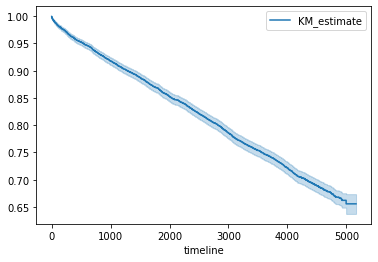

In [34]:
kmf = KaplanMeierFitter()
kmf.fit(all_df["futime"], event_observed=all_df["death"])
kmf.plot_survival_function()

Text(0.5, 0, 'Days since enrollment')

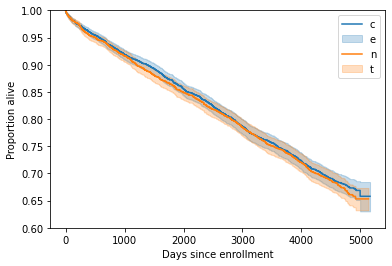

In [35]:
gb = all_df.groupby("sex")
ax = plt.axes()
sexes = []
for group_name, group_df in gb:
    sexes.append(group_name)
    kmf = KaplanMeierFitter()
    kmf.fit(
        group_df["futime"], event_observed=group_df["death"], label=group_name
    )
    kmf.plot_survival_function(ax=ax)
li = ax.get_lines()
#li[1].set_visible(False)
#li[3].set_visible(False)
plt.legend( "center right")
plt.ylim(0.6, 1)
ax.set_ylabel("Proportion alive")
ax.set_xlabel("Days since enrollment")

In [43]:
cph = CoxPHFitter()

cph_df = all_df[['futime', 'death', 'kappa', 'lambda']]
display(cph_df.head(20))
cph.fit(cph_df, duration_col='futime', event_col='death')
cph.print_summary()

,futime,death,kappa,lambda
0,85,1,5.700,4.860
1,1281,1,0.870,0.683
2,69,1,4.360,3.850
3,115,1,2.420,2.220
4,1039,1,1.320,1.690
5,1355,1,2.010,1.860
6,2851,1,0.430,0.880
7,372,1,2.470,2.700
8,3309,1,1.910,2.180
9,1326,1,0.791,2.220


C:\Users\Dell5520\PycharmProjects\personal\machine_learning\venv\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 6524 total observations, 4562 right-censored observations>
             duration col = 'futime'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 6524
number of events observed = 1962
   partial log-likelihood = -16506.80
         time fit was run = 2022-06-05 12:03:03 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
kappa       0.15       1.17       0.02             0.11             0.19                 1.12                 1.21
lambda      0.11       1.11       0.02             0.07             0.15                 1.07                 1.16

            cmp to    z      p   -log2(p)
covariate                                
kappa         0.00 7.43 <0.005      43.10
lambda        0.00 5.29 <0.005      23.00
---
Concordance = 0.67
Partial AIC = 33017.61
log-likelihood ratio test = 391.24 on 2 df
-log2(p) of ll-ratio test = 282.22

In [44]:
cph = CoxPHFitter()
cph_df = all_df[['futime', 'death', 'age', 'sample.yr', 'kappa', 'lambda', 'flc.grp', 'creatinine', 'mgus']]
display(cph_df.head(20))
cph.fit(cph_df, duration_col='futime', event_col='death')
cph.print_summary()

,futime,death,age,sample.yr,kappa,lambda,flc.grp,creatinine,mgus
0,85,1,97,1997,5.700,4.860,10,1.7,0
1,1281,1,92,2000,0.870,0.683,1,0.9,0
2,69,1,94,1997,4.360,3.850,10,1.4,0
3,115,1,92,1996,2.420,2.220,9,1.0,0
4,1039,1,93,1996,1.320,1.690,6,1.1,0
5,1355,1,90,1997,2.010,1.860,9,1.0,0
6,2851,1,90,1996,0.430,0.880,1,0.8,0
7,372,1,90,1999,2.470,2.700,10,1.2,0
8,3309,1,93,1996,1.910,2.180,9,1.2,0
9,1326,1,91,1996,0.791,2.220,6,0.8,0


C:\Users\Dell5520\PycharmProjects\personal\machine_learning\venv\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 6524 total observations, 4562 right-censored observations>
             duration col = 'futime'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 6524
number of events observed = 1962
   partial log-likelihood = -15459.43
         time fit was run = 2022-06-05 12:03:19 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
age          0.10       1.10       0.00             0.09             0.10                 1.10                 1.11
sample.yr    0.05       1.05       0.02             0.02             0.09                 1.02                 1.09
kappa        0.01       1.01       0.03            -0.06             0.07                 0.94                 1.08
lambda       0.16       1.18       0.03             0.11             0.22                 1.12                 1.24
flc.grp      0.06       1.07       0.01             0.04             0.08                 1.05                 1.09
creatinine   0.10       1.10       0.05             0.01             0.19                 1.01                 1.20
mgus         0.27       1.31       0.25            -0.23             0.77                 0.80                 2.16

             cmp to     z      p   -log2(p)
covariate                                  
age            0.00 40.34 <0.005        inf
sample.yr      0.00  2.75   0.01       7.40
kappa          0.00  0.19   0.85       0.24
lambda         0.00  5.90 <0.005      27.99
flc.grp        0.00  6.20 <0.005      30.75
creatinine     0.00  2.10   0.04       4.80
mgus           0.00  1.07   0.29       1.80
---
Concordance = 0.79
Partial AIC = 30932.86
log-likelihood ratio test = 2485.99 on 7 df
-log2(p) of ll-ratio test = inf